# GVB Visualization

## Imports

In [1]:
import pandas as pd
import datetime

#Visualizations
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

## Import Files

In [16]:
#Full GVB Dataset
gvb_df = pd.read_csv("../../../Data_thesis/Full_Datasets/GVBData.csv")

In [17]:
gvb_df.head()

,Date,Hour,Nieuwmarkt Arrivals,Nieuwezijds Kolk Arrivals,Dam Arrivals,Spui Arrivals,Nieuwmarkt Departures,Nieuwezijds Kolk Departures,Dam Departures,Spui Departures,weekday,is_weekend
0,2018-01-01,100,11.0,0.0,0.0,0.0,340.0,27.0,0.0,0.0,0,0
1,2018-01-01,200,48.0,0.0,21.0,0.0,175.0,130.0,39.0,0.0,0,0
2,2018-01-01,300,10.0,16.0,13.0,0.0,137.0,17.0,48.0,0.0,0,0
3,2018-01-01,400,16.0,0.0,0.0,0.0,48.0,46.0,34.0,0.0,0,0
4,2018-01-01,500,17.0,0.0,0.0,0.0,56.0,0.0,20.0,0.0,0,0


## Functions

In [18]:
def plotArrDep(niew, nwz, dam, spui, title):
    dam.plot(legend=True, title=title, label="Dam")
    niew.plot(legend=True, label="Nieuwmarkt")
    nwz.plot(legend=True, label="Nieuwezijdse Kolk")
    spui.plot(legend=True, label="Spui")
    plt.show()

In [19]:
def ConstArrDep(start_date, end_date):
    #Nieuwmarkt
    niew_arr = {}
    niew_dep = {}

    #Nieuwezijds
    nwz_arr = {}
    nwz_dep = {}

    #Dam
    dam_arr = {}
    dam_dep = {}

    #Spui
    spui_arr = {}
    spui_dep = {}

    gvb_dict = gvb_df.to_dict("index")

    for k, v in gvb_dict.items():

        #Combine date and time
        t = int(v["Hour"]/100)

        if t == 24:
            t = 0

        v["Date"] = pd.Timestamp.strptime(v["Date"], "%Y-%m-%d")

        if v["Date"] >= start_date and v["Date"] <= end_date:

            d = datetime.datetime.combine(v["Date"], datetime.time(t,0))
            #Nieuwmarkt
            niew_arr[d] = v["Nieuwmarkt Arrivals"]
            niew_dep[d] = v["Nieuwmarkt Departures"]

            #Nieuwezijds
            nwz_arr[d] = v["Nieuwezijds Kolk Arrivals"]
            nwz_dep[d] = v["Nieuwezijds Kolk Departures"]

            #Dam
            dam_arr[d] = v["Dam Arrivals"]
            dam_dep[d] = v["Dam Departures"]

            #Spui
            spui_arr[d] = v["Spui Arrivals"]
            spui_dep[d] = v["Spui Departures"]

    #Nieuwmarkt
    niew_arr_series = pd.Series(niew_arr)
    niew_dep_series = pd.Series(niew_dep)

    #Nieuwezijds
    nwz_arr_series = pd.Series(nwz_arr)
    nwz_dep_series = pd.Series(nwz_dep)

    #Dam
    dam_arr_series = pd.Series(dam_arr)
    dam_dep_series = pd.Series(dam_dep)

    #Spui
    spui_arr_series = pd.Series(spui_arr)
    spui_dep_series = pd.Series(spui_dep)
    
    plotArrDep(niew_arr_series, nwz_arr_series, dam_arr_series, spui_arr_series, "Arrivals")
    plotArrDep(niew_dep_series, nwz_dep_series, dam_dep_series, spui_dep_series, "Departures")

## Plots

### 2018

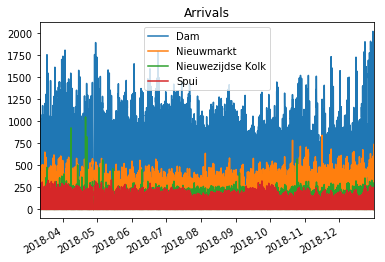

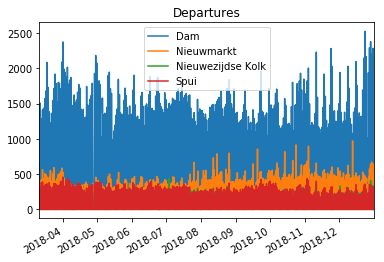

In [20]:
start_date = pd.Timestamp(2018, 3, 11)
end_date = pd.Timestamp(2018, 12, 31)

ConstArrDep(start_date, end_date)

#### March

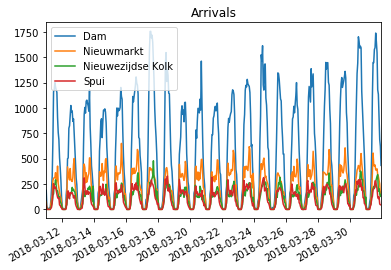

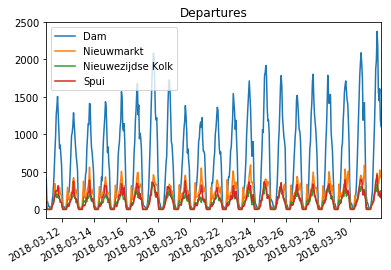

In [21]:
start_date = pd.Timestamp(2018, 3, 11)
end_date = pd.Timestamp(2018, 3, 31)

ConstArrDep(start_date, end_date)

#### April

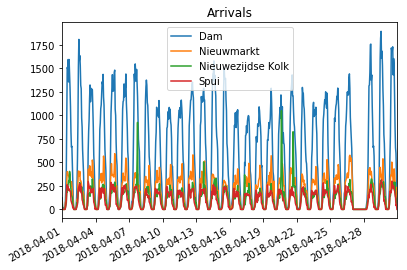

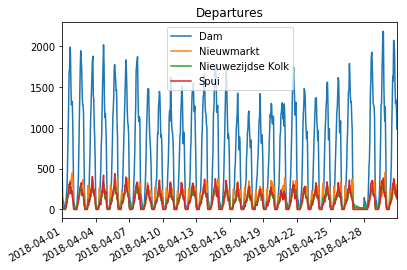

In [22]:
start_date = pd.Timestamp(2018, 4, 1)
end_date = pd.Timestamp(2018, 4, 30)

ConstArrDep(start_date, end_date)

#### May

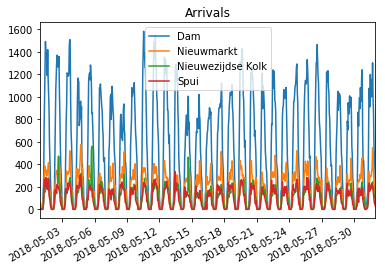

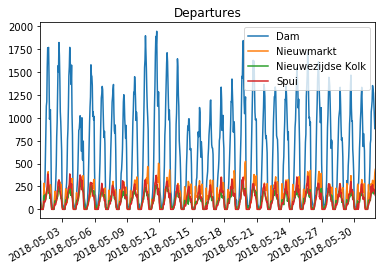

In [23]:
start_date = pd.Timestamp(2018, 5, 1)
end_date = pd.Timestamp(2018, 5, 31)

ConstArrDep(start_date, end_date)

#### June

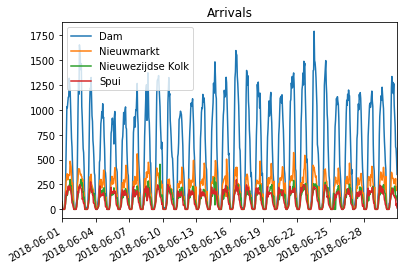

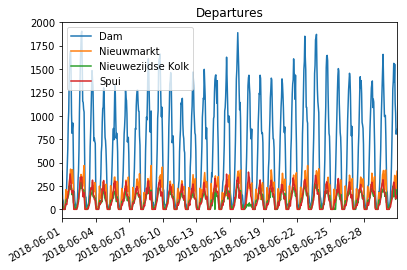

In [24]:
start_date = pd.Timestamp(2018, 6, 1)
end_date = pd.Timestamp(2018, 6, 30)

ConstArrDep(start_date, end_date)

#### July

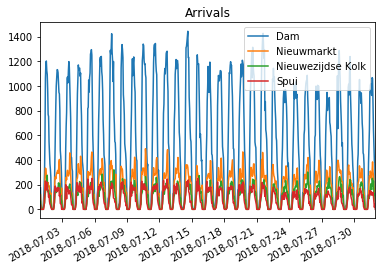

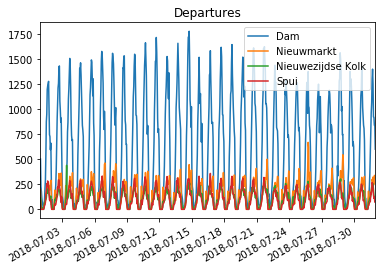

In [25]:
start_date = pd.Timestamp(2018, 7, 1)
end_date = pd.Timestamp(2018, 7, 31)

ConstArrDep(start_date, end_date)

#### August

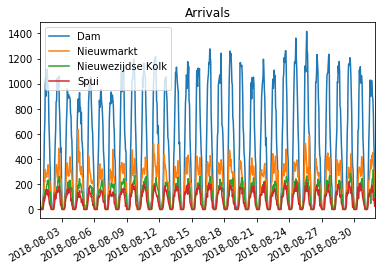

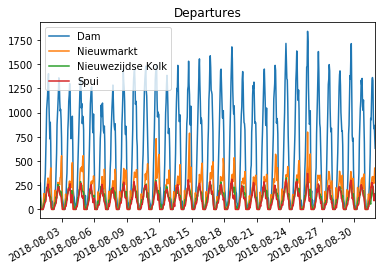

In [26]:
start_date = pd.Timestamp(2018, 8, 1)
end_date = pd.Timestamp(2018, 8, 31)

ConstArrDep(start_date, end_date)

#### September

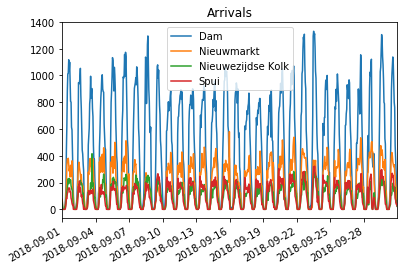

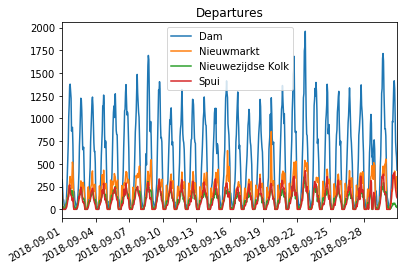

In [27]:
start_date = pd.Timestamp(2018, 9, 1)
end_date = pd.Timestamp(2018, 9, 30)

ConstArrDep(start_date, end_date)

#### October

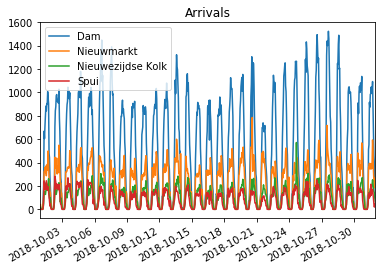

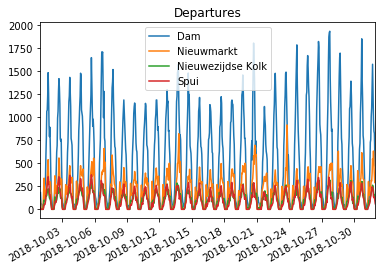

In [28]:
start_date = pd.Timestamp(2018, 10, 1)
end_date = pd.Timestamp(2018, 10, 31)

ConstArrDep(start_date, end_date)

#### November

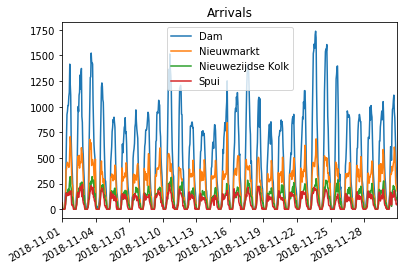

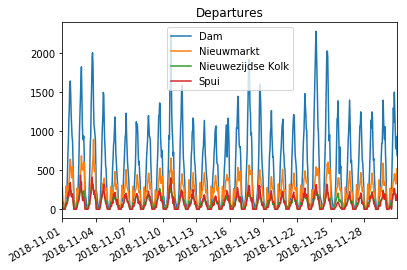

In [29]:
start_date = pd.Timestamp(2018, 11, 1)
end_date = pd.Timestamp(2018, 11, 30)

ConstArrDep(start_date, end_date)

#### December

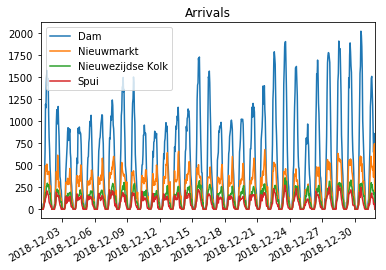

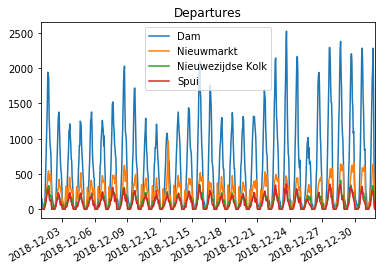

In [30]:
start_date = pd.Timestamp(2018, 12, 1)
end_date = pd.Timestamp(2018, 12, 31)

ConstArrDep(start_date, end_date)

### 2019

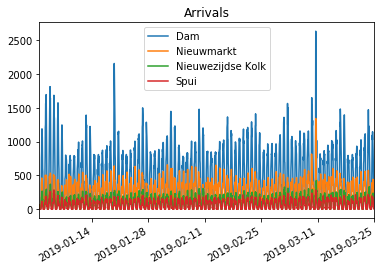

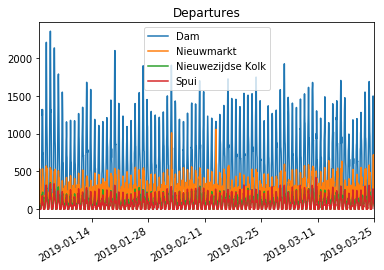

In [31]:
start_date = pd.Timestamp(2019, 1, 1)
end_date = pd.Timestamp(2019, 4, 30)

ConstArrDep(start_date, end_date)

#### January

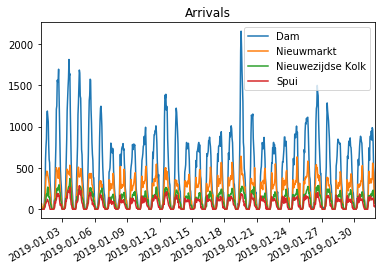

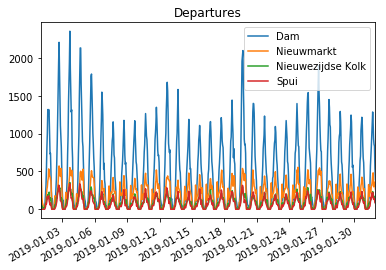

In [32]:
start_date = pd.Timestamp(2019, 1, 1)
end_date = pd.Timestamp(2019, 1, 31)

ConstArrDep(start_date, end_date)

#### February

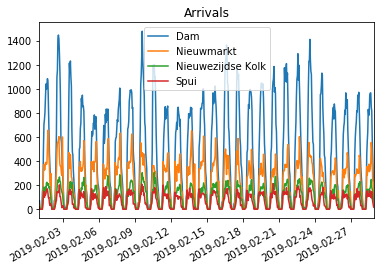

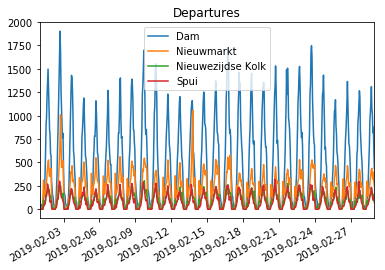

In [33]:
start_date = pd.Timestamp(2019, 2, 1)
end_date = pd.Timestamp(2019, 2, 28)

ConstArrDep(start_date, end_date)

#### March

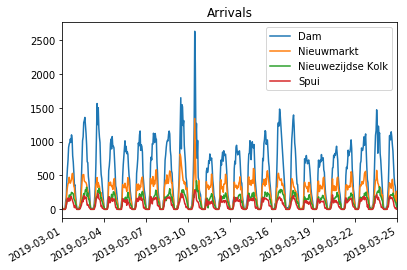

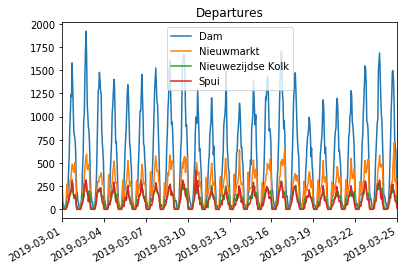

In [34]:
start_date = pd.Timestamp(2019, 3, 1)
end_date = pd.Timestamp(2019, 3, 31)

ConstArrDep(start_date, end_date)